In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
import bartz
from stochtree import BARTModel
import time

## Abalone Data

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 

# variable information 
print(abalone.variables)

             name     role         type demographic  \
0             Sex  Feature  Categorical        None   
1          Length  Feature   Continuous        None   
2        Diameter  Feature   Continuous        None   
3          Height  Feature   Continuous        None   
4    Whole_weight  Feature   Continuous        None   
5  Shucked_weight  Feature   Continuous        None   
6  Viscera_weight  Feature   Continuous        None   
7    Shell_weight  Feature   Continuous        None   
8           Rings   Target      Integer        None   

                   description  units missing_values  
0         M, F, and I (infant)   None             no  
1    Longest shell measurement     mm             no  
2      perpendicular to length     mm             no  
3           with meat in shell     mm             no  
4                whole abalone  grams             no  
5               weight of meat  grams             no  
6  gut weight (after bleeding)  grams             no  
7        

In [3]:
print(X.describe())

            Length     Diameter       Height  Whole_weight  Shucked_weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       Viscera_weight  Shell_weight  
count     4177.000000   4177.000000  
mean         0.180594      0.238831  
std          0.109614      0.139203  
min          0.000500      0.001500  
25%          0.093500      0.130000  
50%          0.171000      0.234000  
75%          0.253000      0.32

In [4]:
if 'Sex' in X.columns:
    print("\nSex value counts:")
    print(X['Sex'].value_counts())


Sex value counts:
Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


In [5]:
X = X.drop(columns=['Sex'])
X

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


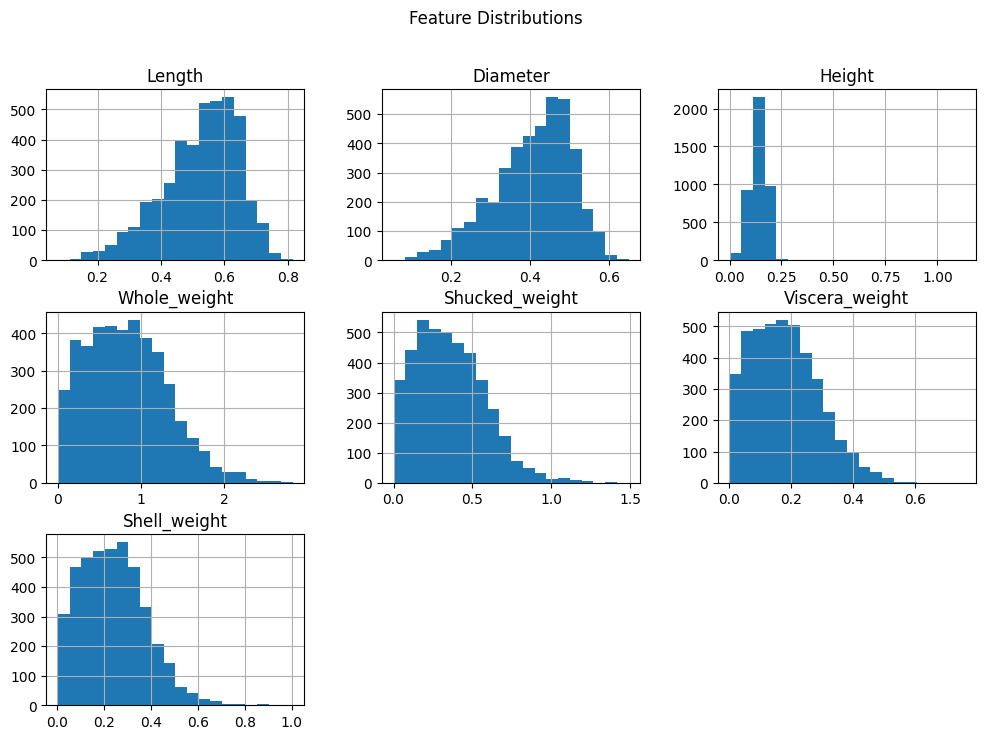

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

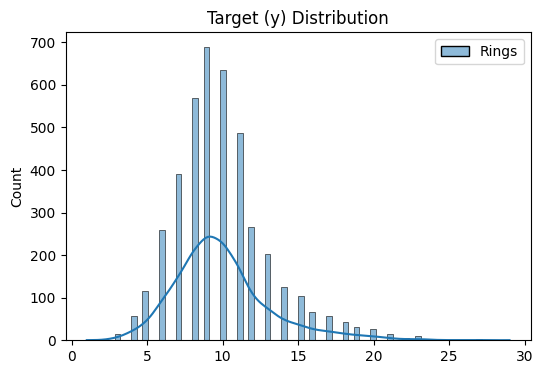

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

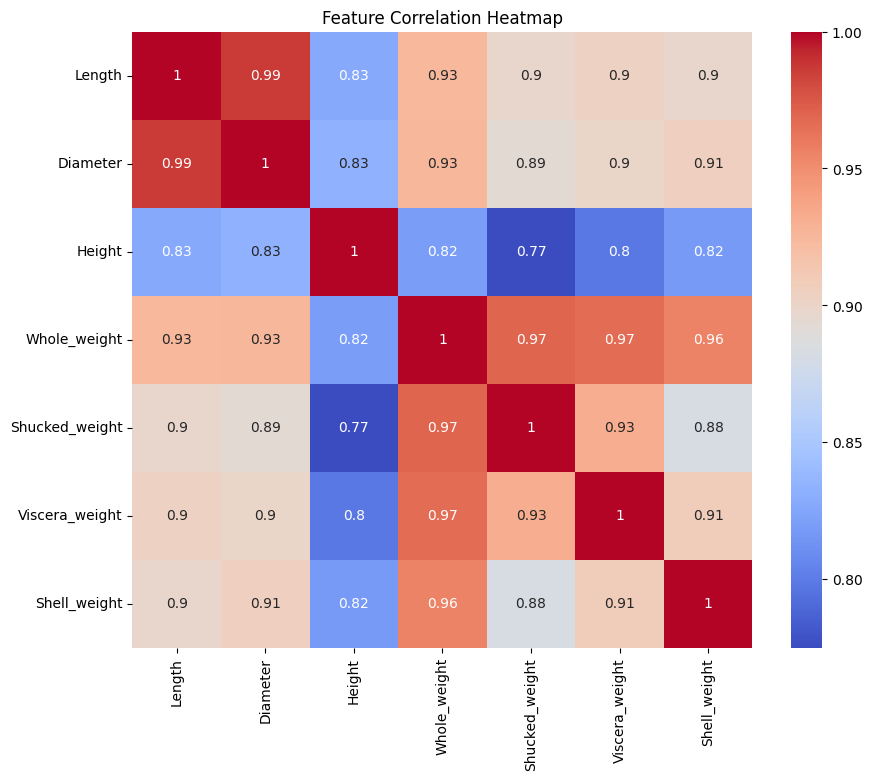

In [8]:
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [10]:
test_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
train_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
pi_length_results = {name: [] for name in ["bart", "btz", "sto"]}
coverage_results = {name: [] for name in ["bart", "btz", "sto"]}
time_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}

In [11]:
n_runs = 10
n_skip = 100
n_post = 300
n_trees = 300

for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    # bart
    t0 = time.time()
    bart = DefaultBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees, 
                       f_k=4.0, eps_nu=7.0, random_state=seed)
    bart.fit(X_train, y_train)
    time_results["bart"].append(time.time() - t0)
    
    # btz
    t0 = time.time()
    btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=n_trees, ndpost=n_post, nskip=n_skip,
                           k=3.0, sigdf=5.0, seed=seed)
    btpred_all_test = btz.predict(np.transpose(X_test))
    btpred_all_test = np.array(btpred_all_test)
    btpred_test = np.mean(np.array(btpred_all_test), axis=0)
    btpred_all_train = btz.predict(np.transpose(X_train))
    btpred_train = np.mean(np.array(btpred_all_train), axis=0)
    time_results["btz"].append(time.time() - t0)
    
    # sto
    t0 = time.time()
    sto = BARTModel()
    sto.sample(X_train=X_train, y_train=y_train,
               num_gfr=0, num_burnin=n_skip, num_mcmc=n_post, 
               mean_forest_params={"num_trees": n_trees, "sigma2_leaf_shape": 5.0}, 
               general_params = {"sigma2_global_shape": 0.0,  "sigma2_global_scale": 2.0, "random_seed": seed},
               variance_forest_params={"num_trees": n_trees // 2}) 
    sto_pred_all_test, sto_all_sigma = sto.predict(X_test)
    sto_pred_test = np.mean(sto_pred_all_test, axis=1)
    sto_pred_train = np.mean(sto.predict(X_train)[0], axis=1)
    time_results["sto"].append(time.time() - t0)

    # rf
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators=300, max_depth=20, max_features="log2", random_state=seed)
    rf.fit(X_train, y_train)
    time_results["rf"].append(time.time() - t0)

    # xgb
    t0 = time.time()
    xgbr = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=seed, verbosity=0)
    xgbr.fit(X_train, y_train)
    time_results["xgb"].append(time.time() - t0)

    # lr
    t0 = time.time()
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    time_results["lr"].append(time.time() - t0)
    
    # Test MSE
    test_mse_results["bart"].append(mean_squared_error(y_test, bart.predict(X_test)))
    test_mse_results["btz"].append(mean_squared_error(y_test, btpred_test))
    test_mse_results["sto"].append(mean_squared_error(y_test, sto_pred_test))
    test_mse_results["rf"].append(mean_squared_error(y_test, rf.predict(X_test)))
    test_mse_results["xgb"].append(mean_squared_error(y_test, xgbr.predict(X_test)))
    test_mse_results["lr"].append(mean_squared_error(y_test, lr.predict(X_test)))

    # Train MSE
    train_mse_results["bart"].append(mean_squared_error(y_train, bart.predict(X_train)))
    train_mse_results["btz"].append(mean_squared_error(y_train, btpred_train))
    train_mse_results["sto"].append(mean_squared_error(y_train, sto_pred_train))
    train_mse_results["rf"].append(mean_squared_error(y_train, rf.predict(X_train)))
    train_mse_results["xgb"].append(mean_squared_error(y_train, xgbr.predict(X_train)))
    train_mse_results["lr"].append(mean_squared_error(y_train, lr.predict(X_train)))

    # Prediction intervals
    # btz: axis=0, shape (n_mcmc, n_test)
    eps = np.zeros_like(btpred_all_test)
    for i in range(n_post):
        eps[i] = np.random.normal(0, btz.sigma[i], size=btpred_all_test.shape[1])
        btpred_all_test[i, :] += eps[i]    
    btz_lower = np.percentile(btpred_all_test, 2.5, axis=0)
    btz_upper = np.percentile(btpred_all_test, 97.5, axis=0)
    pi_length_results["btz"].append(np.mean(btz_upper - btz_lower))
    btz_covered = ((y_test >= btz_lower) & (y_test <= btz_upper)).mean()
    coverage_results["btz"].append(btz_covered)
    
    # sto: axis=1, shape (n_test, n_mcmc)
    sto_eps = np.zeros_like(sto_pred_all_test)
    for i in range(n_post):
        sto_eps[:, i] = np.random.normal(np.zeros(sto_pred_all_test.shape[0]), sto_all_sigma[:, i])
        sto_pred_all_test[:, i] += sto_eps[:, i]
    sto_lower = np.percentile(sto_pred_all_test, 2.5, axis=1)
    sto_upper = np.percentile(sto_pred_all_test, 97.5, axis=1)
    pi_length_results["sto"].append(np.mean(sto_upper - sto_lower))
    sto_covered = ((y_test >= sto_lower) & (y_test <= sto_upper)).mean()
    coverage_results["sto"].append(sto_covered)
    
    # bart: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart.posterior_predict(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart"].append(bart_covered)

Iterations: 100%|██████████| 400/400 [01:51<00:00,  3.60it/s]
INFO:2025-06-09 02:58:37,504:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-09 02:58:37,507:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/400 P_grow=0.53 P_prune=0.47 A_grow=0.30 A_prune=0.30 (burnin)
Iteration 200/400 P_grow=0.53 P_prune=0.47 A_grow=0.28 A_prune=0.22
Iteration 300/400 P_grow=0.49 P_prune=0.51 A_grow=0.22 A_prune=0.27
Iteration 400/400 P_grow=0.56 P_prune=0.44 A_grow=0.22 A_prune=0.31


Iterations: 100%|██████████| 400/400 [01:41<00:00,  3.94it/s]


Iteration 100/400 P_grow=0.54 P_prune=0.46 A_grow=0.24 A_prune=0.28 (burnin)
Iteration 200/400 P_grow=0.53 P_prune=0.47 A_grow=0.28 A_prune=0.30
Iteration 300/400 P_grow=0.57 P_prune=0.43 A_grow=0.26 A_prune=0.32
Iteration 400/400 P_grow=0.55 P_prune=0.45 A_grow=0.28 A_prune=0.28


Iterations: 100%|██████████| 400/400 [02:09<00:00,  3.08it/s]


Iteration 100/400 P_grow=0.53 P_prune=0.47 A_grow=0.16 A_prune=0.32 (burnin)
Iteration 200/400 P_grow=0.53 P_prune=0.47 A_grow=0.24 A_prune=0.28
Iteration 300/400 P_grow=0.53 P_prune=0.47 A_grow=0.25 A_prune=0.30
Iteration 400/400 P_grow=0.58 P_prune=0.42 A_grow=0.27 A_prune=0.33


Iterations: 100%|██████████| 400/400 [02:22<00:00,  2.81it/s]


Iteration 100/400 P_grow=0.54 P_prune=0.46 A_grow=0.28 A_prune=0.25 (burnin)
Iteration 200/400 P_grow=0.56 P_prune=0.44 A_grow=0.22 A_prune=0.29
Iteration 300/400 P_grow=0.58 P_prune=0.42 A_grow=0.28 A_prune=0.29
Iteration 400/400 P_grow=0.55 P_prune=0.45 A_grow=0.25 A_prune=0.29


Iterations: 100%|██████████| 400/400 [02:22<00:00,  2.80it/s]


Iteration 100/400 P_grow=0.54 P_prune=0.46 A_grow=0.27 A_prune=0.20 (burnin)
Iteration 200/400 P_grow=0.51 P_prune=0.49 A_grow=0.18 A_prune=0.32
Iteration 300/400 P_grow=0.53 P_prune=0.47 A_grow=0.23 A_prune=0.34
Iteration 400/400 P_grow=0.53 P_prune=0.47 A_grow=0.27 A_prune=0.26


Iterations: 100%|██████████| 400/400 [02:19<00:00,  2.86it/s]


Iteration 100/400 P_grow=0.53 P_prune=0.47 A_grow=0.27 A_prune=0.27 (burnin)
Iteration 200/400 P_grow=0.55 P_prune=0.45 A_grow=0.25 A_prune=0.28
Iteration 300/400 P_grow=0.53 P_prune=0.47 A_grow=0.22 A_prune=0.30
Iteration 400/400 P_grow=0.54 P_prune=0.46 A_grow=0.23 A_prune=0.32


Iterations: 100%|██████████| 400/400 [02:28<00:00,  2.69it/s]


Iteration 100/400 P_grow=0.53 P_prune=0.47 A_grow=0.26 A_prune=0.27 (burnin)
Iteration 200/400 P_grow=0.55 P_prune=0.45 A_grow=0.23 A_prune=0.26
Iteration 300/400 P_grow=0.53 P_prune=0.47 A_grow=0.21 A_prune=0.27
Iteration 400/400 P_grow=0.53 P_prune=0.47 A_grow=0.22 A_prune=0.30


Iterations: 100%|██████████| 400/400 [02:27<00:00,  2.72it/s]


Iteration 100/400 P_grow=0.56 P_prune=0.44 A_grow=0.30 A_prune=0.28 (burnin)
Iteration 200/400 P_grow=0.56 P_prune=0.44 A_grow=0.19 A_prune=0.27
Iteration 300/400 P_grow=0.50 P_prune=0.50 A_grow=0.21 A_prune=0.34
Iteration 400/400 P_grow=0.53 P_prune=0.47 A_grow=0.29 A_prune=0.29


Iterations: 100%|██████████| 400/400 [02:34<00:00,  2.59it/s]


Iteration 100/400 P_grow=0.56 P_prune=0.44 A_grow=0.27 A_prune=0.33 (burnin)
Iteration 200/400 P_grow=0.51 P_prune=0.49 A_grow=0.24 A_prune=0.30
Iteration 300/400 P_grow=0.57 P_prune=0.43 A_grow=0.20 A_prune=0.31
Iteration 400/400 P_grow=0.56 P_prune=0.44 A_grow=0.20 A_prune=0.33


Iterations: 100%|██████████| 400/400 [02:34<00:00,  2.59it/s]


Iteration 100/400 P_grow=0.53 P_prune=0.47 A_grow=0.22 A_prune=0.29 (burnin)
Iteration 200/400 P_grow=0.53 P_prune=0.47 A_grow=0.26 A_prune=0.22
Iteration 300/400 P_grow=0.51 P_prune=0.49 A_grow=0.23 A_prune=0.33
Iteration 400/400 P_grow=0.58 P_prune=0.42 A_grow=0.25 A_prune=0.22


In [12]:
import pandas as pd

test_mse_df = pd.DataFrame(test_mse_results)
train_mse_df = pd.DataFrame(train_mse_results)
pi_length_df = pd.DataFrame(pi_length_results)
coverage_df = pd.DataFrame(coverage_results)
time_df = pd.DataFrame(time_results)

print(f"Test MSE ({n_runs} runs):")
print(f"Train MSE ({n_runs} runs):")
print("Test MSE Mean:")
print(test_mse_df.mean())
print("Train MSE Mean:")
print(train_mse_df.mean())

print(f"Prediction Interval Mean Length ({n_runs} runs):")
print(f"Prediction Interval Mean Length (Mean over {n_runs} runs):")
print(pi_length_df.mean())

print(f"Prediction Interval Coverage Mean ({n_runs} runs):")
print(coverage_df.mean())

print(f"Average Training Time (seconds) over {n_runs} runs:")
print(time_df.mean())

Test MSE (10 runs):
Train MSE (10 runs):
Test MSE Mean:
bart    4.754766
btz     4.778947
sto     4.866623
rf      4.813441
xgb     4.881207
lr      5.072859
dtype: float64
Train MSE Mean:
bart    3.956405
btz     3.939271
sto     4.264909
rf      0.654367
xgb     3.707819
lr      4.869678
dtype: float64
Prediction Interval Mean Length (10 runs):
Prediction Interval Mean Length (Mean over 10 runs):
bart    8.145309
btz     8.142558
sto     7.612299
dtype: float64
Prediction Interval Coverage Mean (10 runs):
bart    0.933493
btz     0.932153
sto     0.933876
dtype: float64
Average Training Time (seconds) over 10 runs:
bart    137.311627
btz      49.382245
sto      32.768595
rf        1.995895
xgb       0.053179
lr        0.002105
dtype: float64


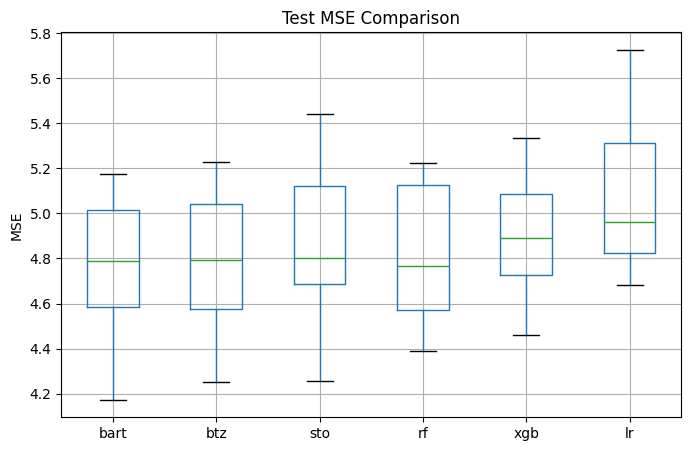

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
test_mse_df.boxplot()
plt.title("Test MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

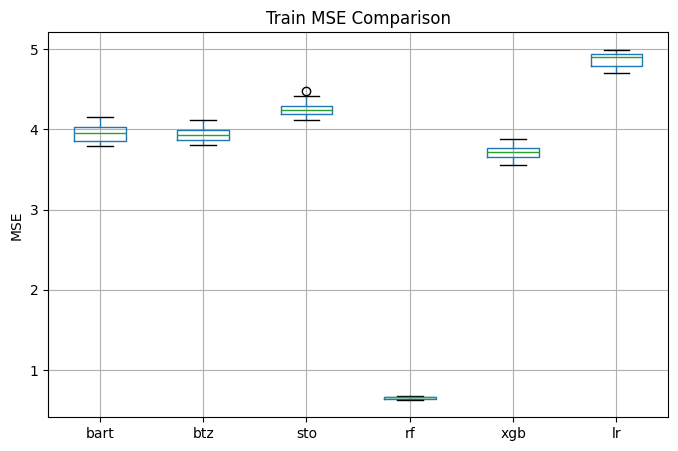

In [14]:
plt.figure(figsize=(8, 5))
train_mse_df.boxplot()
plt.title("Train MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

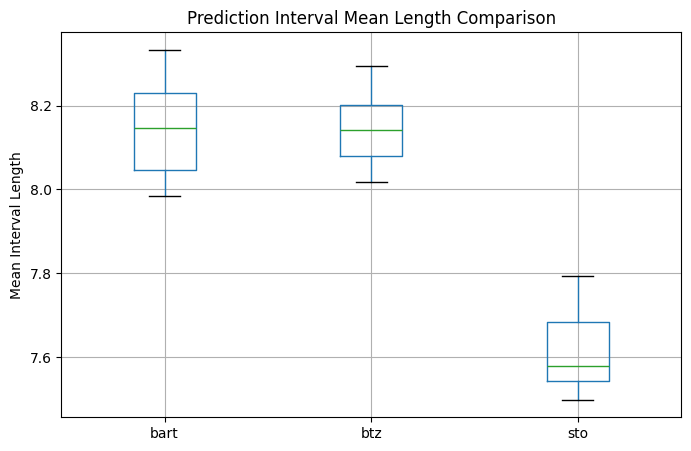

In [15]:
plt.figure(figsize=(8, 5))
pi_length_df.boxplot()
plt.title("Prediction Interval Mean Length Comparison")
plt.ylabel("Mean Interval Length")
plt.grid(True, axis='y')
plt.show()

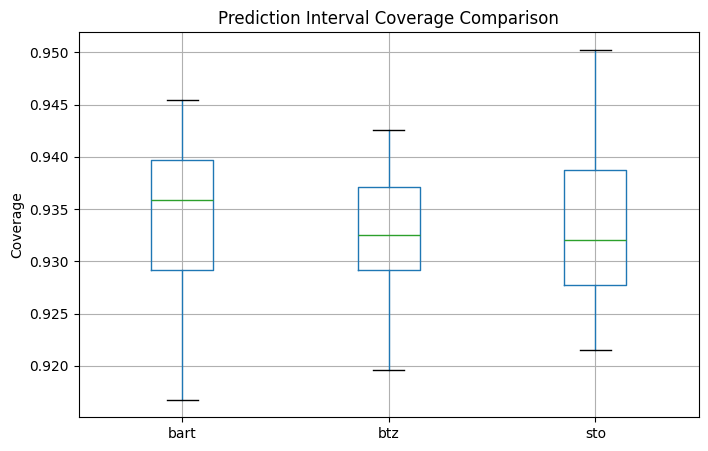

In [16]:
plt.figure(figsize=(8, 5))
coverage_df.boxplot()
plt.title("Prediction Interval Coverage Comparison")
plt.ylabel("Coverage")
plt.grid(True, axis='y')
plt.show()

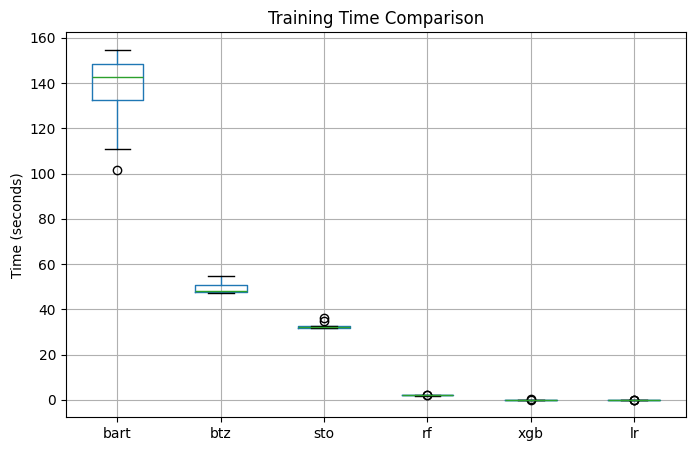

In [17]:
plt.figure(figsize=(8, 5))
time_df.boxplot()
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(True, axis='y')
plt.show()